### Example for reading the LENS2 dataset and extract SST time-series for case 1

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
# Load marineHeatWaves definition module
import marineHeatWaves as mhw
from distributed import Client
from ncar_jobqueue import NCARCluster
import intake
import pop_tools
from misc import get_ij
import warnings
warnings.filterwarnings("ignore")

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = NCARCluster(cores=4,
    processes=1,
    resource_spec='select=1:ncpus=1:mem=50GB',
)
cluster.scale(20)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.35:34538,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)
catalog

,unique
component,6
stream,26
case,200
member_id,100
variable,1906
start_time,157
end_time,180
time_range,163
long_name,1800
units,184


In [4]:
cat_subset = catalog.search(component='ocn', 
               variable='SST',
               frequency='day_1') #.unique()

In [5]:
cat_subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ocn,pop.h.nday1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SST,1850-01-01,1860-01-01,18500101-18600101,Surface Potential Temperature,degC,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,ocn,pop.h.nday1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SST,1860-01-02,1870-01-01,18600102-18700101,Surface Potential Temperature,degC,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,ocn,pop.h.nday1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SST,1870-01-02,1880-01-01,18700102-18800101,Surface Potential Temperature,degC,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,ocn,pop.h.nday1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SST,1880-01-02,1890-01-01,18800102-18900101,Surface Potential Temperature,degC,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,ocn,pop.h.nday1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SST,1890-01-02,1900-01-01,18900102-19000101,Surface Potential Temperature,degC,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1


In [6]:
%%time
dset_dict_raw = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 8s, sys: 2.98 s, total: 1min 11s
Wall time: 3min 22s


In [7]:
[key for key in dset_dict_raw.keys()]

['ocn.ssp370.pop.h.nday1.cmip6.SST',
 'ocn.historical.pop.h.nday1.smbb.SST',
 'ocn.historical.pop.h.nday1.cmip6.SST',
 'ocn.ssp370.pop.h.nday1.smbb.SST']

In [8]:
ds_cmip6 = dset_dict_raw['ocn.historical.pop.h.nday1.cmip6.SST'] 

In [9]:
ds_smbb = dset_dict_raw['ocn.historical.pop.h.nday1.smbb.SST'] 

In [10]:
ds_all = xr.concat([ds_cmip6,ds_smbb], dim='member_id', 
                     data_vars='minimal',coords="minimal",
                     compat="override")
ds_all

<xarray.Dataset>
Dimensions:                 (z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, nlat: 384, nlon: 320, time: 60225, d2: 2, member_id: 100)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) object 1850-01-02 00:00:00 ... 2015-01-01 ...
  * member_id               (member_id) <U12 'r10i1181p1f1' ... 'r9i1171p1f2'
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/52)
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMU                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    UAREA                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object dask.array<chunksize=(3650, 2), meta=np.ndarray>
    SST                     (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 3650, 384, 320), meta=np.ndarray>
Attributes:
    cell_methods:            cell_methods = time: mean ==> the variable value...
    contents:                Diagnostic and Prognostic Variables
    time_period_freq:        day_1
    revision:                $Id$
    intake_esm_varname:      ['SST']
    calendar:                All years have exactly  365 days.
    history:                 none
    source:                  CCSM POP2, the CCSM Ocean Component
    Conventions:             CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf...
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_dataset_key:  ocn.historical.pop.h.nday1.cmip6.SST

In [11]:
# read the pop 1 deg grid from pop_tools
# we will use variables TLONG and TLAT

pop_grid = pop_tools.get_grid('POP_gx1v7')

In [12]:
# in ds, TLONG and TLAT have missing values (NaNs)
# so we need to override them with the values from
# pop_grid, which does not have missing values
ds_cmip6['TLONG'] = pop_grid.TLONG
ds_cmip6['TLAT'] = pop_grid.TLAT

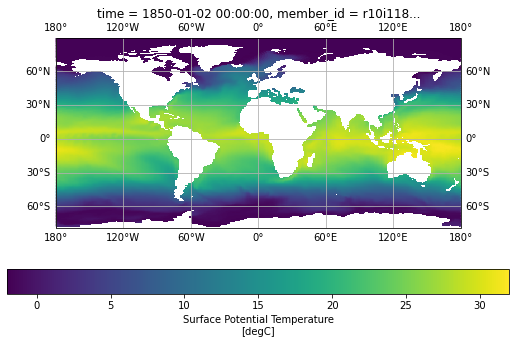

In [13]:
plt.figure(figsize=(9,5));
ax = plt.axes(projection=ccrs.PlateCarree());
pc = ds_cmip6.SST.isel(time=0, member_id=0).plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='TLONG', 
                                    y='TLAT',
                                    vmin=-2,
                                    vmax=32,
                                    cbar_kwargs={"orientation": "horizontal"},)

   
ax.gridlines(draw_labels=True);

### Case study #1: 2011 Western Australia

In this case, we will use a point from Western Australia (WA; 112.5 ∘ E, 29.5 ∘ S) over the 1982 to 2014 period.

We need to find the i,j indices that correspond to the lon, lat values for case 1. Unlike the NOAA OISST dataset, which is represented in a regular lat/lon grid (i.e., one-dimensional lat/lon arrays represent the grid), the POP grid used in the LENS2 simulations is in a curvilinear grid (where two-dimensional lat/lon arrays are used to represent the grid). 

Plot a lat and lon to visualize the location

In [14]:
i, j = get_ij(112.5, -29.5, pop_grid)
print('i = {}, j = {}'.format(i,j))

i = 135, j = 93


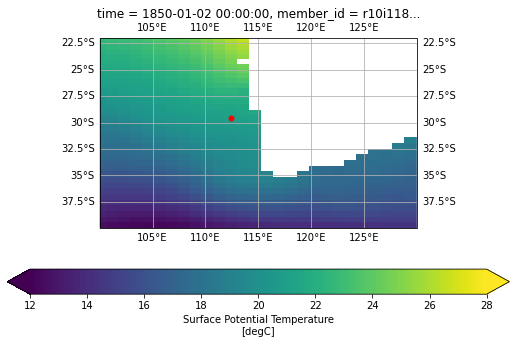

In [15]:
cbar_args = {"orientation": "horizontal"}
plt.figure(figsize=(9,5));
ax = plt.axes(projection=ccrs.PlateCarree());
pc = ds_cmip6.SST.isel(time=0,member_id=0).plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='TLONG', 
                                    y='TLAT',
                                    vmin=12,
                                    vmax=28,
                                    cbar_kwargs=cbar_args)

   
ax.gridlines(draw_labels=True);
ax.plot(ds_cmip6.TLONG[j,i], ds_cmip6.TLAT[j,i], color='r', 
        ms=5,marker='o');
ax.set_xlim(100,130)
ax.set_ylim(-40,-22);

In [16]:
%%time
wa_ds_cmip6 = ds_cmip6.SST.isel(nlon = i, nlat = j, 
             ).sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 4.52 s, sys: 504 ms, total: 5.03 s
Wall time: 3min 23s


In [17]:
%%time
wa_ds_smbb = ds_smbb.SST.isel(nlon = i, nlat = j, 
             ).sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 4.35 s, sys: 466 ms, total: 4.81 s
Wall time: 3min 12s


In [18]:
wa_ds_filtered=xr.open_dataset('wa_ds_remapped.nc').__xarray_dataarray_variable__

In [19]:
#wa_ds_cmip6.time
times = xr.cftime_range("1982-01-01", "2014-12-31", calendar="julian")
len(times)

12053

Text(0.5, 1.0, 'LENS cmip6 (members in lightblue; mean in blue), LENS smbb (members in gray; mean in black), wa_ds_filtered in red')

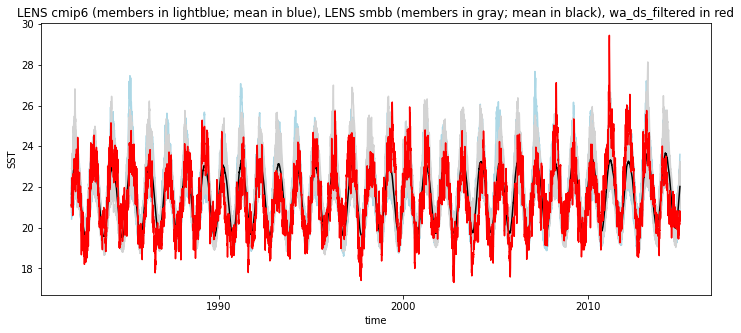

In [20]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))

wa_ds_cmip6.plot(ax=ax,hue="member_id",add_legend=False, color='lightblue', label='historical');
wa_ds_cmip6.mean('member_id').plot(ax=ax,color='blue', label='mean historical')

wa_ds_smbb.plot(ax=ax,hue="member_id",add_legend=False, color='lightgray', label='ssp370');
wa_ds_smbb.mean('member_id').plot(ax=ax,color='black', label='mean ssp370')

ax.plot(times,wa_ds_filtered.values,color='red', label='oisst' )
ax.set_title('LENS cmip6 (members in lightblue; mean in blue), LENS smbb (members in gray; mean in black), wa_ds_filtered in red')

In [21]:
time_idx = wa_ds_cmip6.indexes['time'].to_datetimeindex()
t = np.zeros(len(time_idx))
for i in range(len(time_idx)):
  t[i] = date(time_idx[i].year, time_idx[i].month, time_idx[i].day).toordinal()

t = t.astype(int)

In [22]:
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [23]:
mhhs_cmip6 = []
clim_cmip6 = []
for i in range(len(wa_ds_cmip6.member_id)):
    mhws, clim = mhw.detect(t, wa_ds_cmip6[i,:].values)
    mhhs_cmip6.append(mhws)
    clim_cmip6.append(clim)

In [24]:
mhhs_smbb = []
clim_smbb = []
for i in range(len(wa_ds_smbb.member_id)):
    mhws, clim = mhw.detect(t, wa_ds_smbb[i,:].values)
    mhhs_smbb.append(mhws)
    clim_smbb.append(clim)

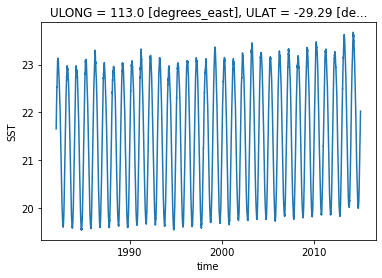

In [36]:
wa_ds_smbb.mean('member_id').plot()

In [65]:
mhhs_cmip6[i]['intensity_max']

[2.906166814988662,
 0.9375369779525293,
 1.368282871861613,
 2.295741850329982,
 0.6900652608563789,
 0.8062210698281547,
 1.1450809355705012,
 0.5348011755174227,
 0.8069015010710672,
 2.4283916104224446,
 1.0683120604484309,
 1.236975054587088,
 2.2261784461236758,
 1.6734894783266157,
 1.3096787237351926,
 0.5587318174300648,
 1.0397873540078457,
 1.281793317487164,
 1.0001263157013938,
 0.5318844087662207,
 1.2617683410644496,
 0.6186588656517813,
 0.8393152913739605,
 0.9662616483626856,
 1.6484325162826075,
 0.6657723457582527,
 0.8725485032604503,
 1.0440667675387445,
 1.2439994812011683,
 0.7805768289873711,
 0.6003075261269828,
 0.6127497765325742,
 0.7183942487162973,
 0.7102171374905453,
 1.5367995231382316,
 1.217895784685691,
 1.0984452155328626,
 0.5720608618951566]

In [66]:
np.mean(np.array(mhhs_cmip6[i]['intensity_max']))

1.1277478344371648

In [115]:
nevents_cmip6 = []
intensity_cmip6 = []
cat1_cmip6 = []
cat2_cmip6 = []
cat3_cmip6 = []
cat4_cmip6 = []
for i in range(len(wa_ds_cmip6.member_id)):
  nevents_cmip6.append(mhhs_cmip6[i]['n_events'])
  intensity_cmip6.append(np.mean(np.array(mhhs_cmip6[i]['intensity_max'])))
  tmp = np.array(mhhs_cmip6[i]['category'])
  cat1_cmip6.append(len(np.where(tmp=='Moderate')[0]))
  cat2_cmip6.append(len(np.where(tmp=='Strong')[0]))
  cat3_cmip6.append(len(np.where(tmp=='Severe')[0]))
  cat4_cmip6.append(len(np.where(tmp=='Extreme')[0]))

In [112]:
nevents_smbb = []
intensity_smbb = []
for i in range(len(wa_ds_smbb.member_id)):
  nevents_smbb.append(mhhs_smbb[i]['n_events'])
  intensity_smbb.append(np.mean(np.array(mhhs_smbb[i]['intensity_mean'])))

In [ ]:

for i in range(len(wa_ds_cmip6.member_id))
  len(np.where(tmp=='Extreme')[0])

In [69]:
member_id1 = np.arange(1,51)
member_id2 = np.arange(51,101)

(0.0, 101.0)

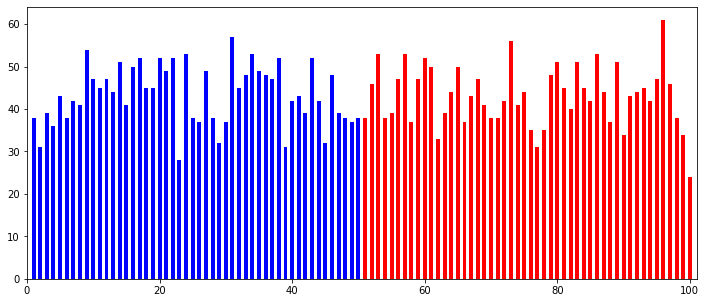

In [70]:
plt.figure(figsize=(12,5))
plt.bar(member_id1,nevents_cmip6,color='blue',width=0.6)
plt.bar(member_id2,nevents_smbb,color='red',width=0.6)
plt.xlim(0,101)

(0.0, 101.0)

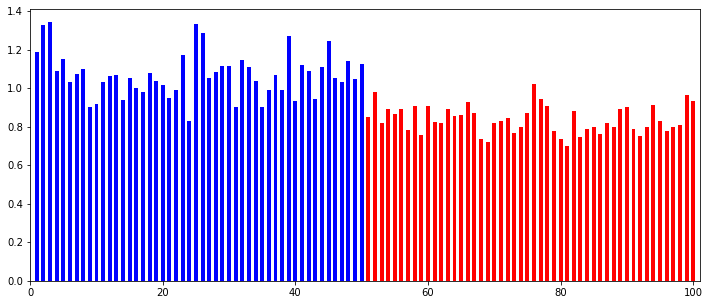

In [73]:
plt.figure(figsize=(12,5))
plt.bar(member_id1,intensity_cmip6,color='blue',width=0.6)
plt.bar(member_id2,intensity_smbb,color='red',width=0.6)
plt.xlim(0,101)

In [31]:
mhws.keys()

dict_keys(['time_start', 'time_end', 'time_peak', 'date_start', 'date_end', 'date_peak', 'index_start', 'index_end', 'index_peak', 'duration', 'duration_moderate', 'duration_strong', 'duration_severe', 'duration_extreme', 'intensity_max', 'intensity_mean', 'intensity_var', 'intensity_cumulative', 'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 'intensity_cumulative_relThresh', 'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', 'intensity_cumulative_abs', 'category', 'rate_onset', 'rate_decline', 'n_events'])